In [2]:
import chachifuncs as ccf
import descriptors as d
import glob
import matplotlib.pyplot as plt 
import numpy as np
import os
import pandas as pd
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pickle

%matplotlib inline

In [3]:
#Looks for any files that have been processed with the describe function 

k_list = [f for f in glob.glob('data/K_descriptors/*.xlsx')]
c_list = [f for f in glob.glob('data/C_descriptors/*.xlsx')]

In [4]:
c_data = pd.DataFrame()
for each in c_list:
    df = pd.read_excel(each)
    c_data = c_data.append(df,ignore_index=True)
c_data.shape

(390, 40)

In [5]:
k_data = pd.DataFrame()
for each in k_list:
    df = pd.read_excel(each)
    k_data = k_data.append(df,ignore_index=True)
k_data.shape

(640, 40)

In [6]:
#append all data and drop any duplicate columns 
data = c_data.append(k_data)
df = data
data = data.T.drop_duplicates().T
data.columns

Index(['ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5', 'ch_6', 'ch_7', 'ch_8',
       'ch_9', 'ch_10', 'ch_11', 'ch_12', 'ch_13', 'ch_14', 'ch_15', 'ch_16',
       'names', 'dc_0', 'dc_1', 'dc_2', 'dc_3', 'dc_4', 'dc_5', 'dc_6', 'dc_7',
       'dc_8', 'dc_9', 'dc_10', 'dc_11', 'dc_12', 'dc_13', 'dc_14', 'dc_15'],
      dtype='object')

In [7]:
df.columns = ['charge_poly_B0','charge_poly_B1','charge_poly_B2','charge_poly_B3','Charge_P1_loc','Charge_P1_height','Charge_P1_width',
              'Charge_P2_loc','Charge_P2_height','Charge_P2_width','Charge_P3_loc','Charge_P3_height','Charge_P3_width',
              'Charge_P4_loc','Charge_P4_height','Charge_P4_width','Charge_P5_loc','Charge_P5_height','Charge_P5_width',
              'names','discharge_poly_B0','discharge_poly_B1','discharge_poly_B2','discharge_poly_B3','Discarge_P1_loc','Disharge_P1_height','Discharge_P1_width','Discarge_P2_loc','Disharge_P2_height',
              'Discharge_P2_width','Discarge_P3_loc','Disharge_P3_height','Discharge_P3_width','Discarge_P4_loc',
              'Disharge_P4_height','Discharge_P4_width','Discarge_P5_loc','Disharge_P5_height','Discharge_P5_width','names']
df = df.T.drop_duplicates().T
df.columns

Index(['charge_poly_B0', 'charge_poly_B1', 'charge_poly_B2', 'charge_poly_B3',
       'Charge_P1_loc', 'Charge_P1_height', 'Charge_P1_width', 'Charge_P2_loc',
       'Charge_P2_height', 'Charge_P2_width', 'Charge_P3_loc',
       'Charge_P3_height', 'Charge_P3_width', 'Charge_P4_loc',
       'Charge_P4_height', 'Charge_P4_width', 'Charge_P5_loc', 'names',
       'discharge_poly_B0', 'discharge_poly_B1', 'discharge_poly_B2',
       'discharge_poly_B3', 'Discarge_P1_loc', 'Disharge_P1_height',
       'Discharge_P1_width', 'Discarge_P2_loc', 'Disharge_P2_height',
       'Discharge_P2_width', 'Discarge_P3_loc', 'Disharge_P3_height',
       'Discharge_P3_width', 'Discarge_P4_loc', 'Disharge_P4_height',
       'Discharge_P4_width'],
      dtype='object')

In [8]:
#reset index
data = data.reset_index(drop = True)

for i in range(len(data)):
    if data.loc[i, ('names')].startswith('CS2_33'):
        data.loc[i, ('label')] = 'LiCoO2'
        data.loc[i, ('lasso')] = 0
    else:
        data.loc[i,('label')] = 'LiFePO4'
        data.loc[i, ('lasso')] = 1

data.label.unique()

array(['LiCoO2', 'LiFePO4'], dtype=object)

In [9]:
print ("Shape of dataset: ",data.shape) #size of dataset
data.head(10) #check 

Shape of dataset:  (1030, 36)


,ch_0,ch_1,ch_2,ch_3,ch_4,ch_5,ch_6,ch_7,ch_8,ch_9,...,dc_8,dc_9,dc_10,dc_11,dc_12,dc_13,dc_14,dc_15,label,lasso
0,216057,-219361,83436.7,-14091.3,3.81096,1.98733,0.0248541,3.90362,3.83951,0.0230099,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
1,81798,-84121.6,32386.1,-5532.19,3.80934,1.74861,3.33851,3.89844,4.11237,0.0254297,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
2,69127.1,-71131,27396.5,-4681.17,3.80416,1.77687,0.519043,3.89746,4.08835,0.0258235,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
3,65078.7,-66829.4,25686.4,-4379.73,3.80788,1.68394,0.325897,3.90346,3.92758,0.0277913,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
4,97590.8,-100242,38551.1,-6579.07,3.81517,1.62222,70.7299,3.90249,3.97789,0.025399,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
5,90553.4,-92961.5,35729.2,-6093.47,3.81388,1.62629,87.808,3.90119,4.00304,0.0259246,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
6,83140.6,-85365.3,32813.8,-5596.76,3.81404,1.60402,0.823952,3.90394,3.94021,0.0275282,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
7,89571.2,-92052.2,35417.5,-6046.67,3.80999,1.6505,57.4664,3.89714,3.87901,0.0252584,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
8,79038.8,-81240.1,31259.6,-5336.77,3.80821,1.66692,7.05149,3.89908,3.84626,0.0284289,...,0,0,0,0,0,0,0,0,LiCoO2,0.0
9,94001.3,-96556.3,37133.1,-6336.83,3.81614,1.62057,7.76953,3.90087,3.84674,0.0249746,...,0,0,0,0,0,0,0,0,LiCoO2,0.0


In [10]:
print("The following features were found: ") #column names 
data.columns

The following features were found: 


Index(['ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5', 'ch_6', 'ch_7', 'ch_8',
       'ch_9', 'ch_10', 'ch_11', 'ch_12', 'ch_13', 'ch_14', 'ch_15', 'ch_16',
       'names', 'dc_0', 'dc_1', 'dc_2', 'dc_3', 'dc_4', 'dc_5', 'dc_6', 'dc_7',
       'dc_8', 'dc_9', 'dc_10', 'dc_11', 'dc_12', 'dc_13', 'dc_14', 'dc_15',
       'label', 'lasso'],
      dtype='object')

In [11]:
unique = data['label'].unique()
print ("There are", len(unique), "unique batteries in this dataset: ", unique) #how many unique batteries are we looking at 

There are 2 unique batteries in this dataset:  ['LiCoO2' 'LiFePO4']


In [12]:
#split up data into test train set 80/20

train,test = train_test_split(data, test_size=0.2, random_state=1010)
print (train.shape, test.shape)

(824, 36) (206, 36)


In [13]:
#LASSO 
#feature selection
train_lasso_y = train['lasso']
train_lasso_x = train[['ch_4','ch_5','ch_7','ch_8','ch_10','ch_11','dc_4','dc_5','dc_7','dc_10','dc_11']] #all the descriptors
test_lasso_y = test['lasso']
test_lasso_x = test[['ch_4','ch_5','ch_7','ch_8','ch_10','ch_11','dc_4','dc_5','dc_7','dc_10','dc_11']]
#4,5,7,8,10,11

train_lasso_x_scaled  = preprocessing.normalize(train_lasso_x, norm='l1')
test_lasso_x_scaled  = preprocessing.normalize(test_lasso_x, norm='l1')

In [14]:
clf = linear_model.Lasso(alpha=0.004, tol=0.0001 ,max_iter=5000)
#clf.fit(train_lasso_x_scaled,train_lasso_y)
clf.fit(train_lasso_x_scaled,train_lasso_y)
coef = clf.coef_

coef

#ch_5,ch_7,ch_5 are the important descriptors 

array([-0.        ,  1.80409918, -0.18324826, -0.        , -0.        ,
       -0.        , -0.        ,  1.41705721, -0.        ,  0.        ,
        0.        ])

In [15]:
train_y = train['lasso'] #what are we predicting 
test_y = train['lasso']

train_x = train[['ch_5','ch_7','dc_5']] #from LASSO 
test_x = test[['ch_5','ch_7','dc_5']]

train_x_scaled  = preprocessing.normalize(train_x, norm='l1')
test_x_scaled  = preprocessing.normalize(test_x, norm='l1')

#print (train_y.shape, train_x.shape) #check y should by (datapoints,), x should by (datapoints,descriptors)

print ("Data points in train/test: ",train_x.shape[0],"/", test_x.shape[0])

Data points in train/test:  824 / 206


In [16]:
#Support Vector Machine 
#-->Chosen under the assumption that eventually more batteries will be added with highly dimensional features that 
# can not be seperated by simple linear or logistic regression models 

lin_svc = svm.LinearSVC().fit(train_x, train_y)
trainpred=lin_svc.predict(train_x_scaled) #predict train data 
testpred=lin_svc.predict(test_x_scaled)

In [17]:
def accuracy(test_df,pred_df):
    """Calculates the amount of data classified correctly"""
    #Input for test_y should be the test dataframe (ex -- see below)
    N= len(pred_df)
    compare = np.array([test_df.lasso, pred_df]).reshape(N,2)
    asses = pd.DataFrame (compare, columns = ['actual','predicted'])
    count = 0
    correct = 0
    for i in range(len(compare)):
        if asses.loc[i,('actual')] == asses.loc[i, ('predicted')]:
            correct += 1 
            count += 1 
            asses.loc[i, ('correct')] = 1
        else: 
            count += 1
            asses.loc[i, ('correct')] = 0
    #print (correct)
    return (1-correct/count)*100, asses

In [18]:
test_error, test_df,  = accuracy(test,testpred)
train_error, train_df,  = accuracy(train,trainpred)
print ("Testing error: ","%.2f" %test_error,"%")
print ("Training error: ","%.2f" %train_error,"%")

Testing error:  20.39 %
Training error:  24.03 %


In [19]:
pd_train_y = pd.DataFrame(train['label'])
frames = [train_x,pd_train_y]
datatot = pd.concat(frames, axis=1, ignore_index = True)
datatot.columns = 'ch_5', 'ch_7','dc_5', 'Label'
datatot.head()

,ch_5,ch_7,dc_5,Label
209,0.741892,0,0.630329,LiCoO2
687,10.6756,0,12.2656,LiFePO4
658,12.0657,0,14.1386,LiFePO4
768,10.2817,0,11.7756,LiFePO4
809,9.91215,0,11.7265,LiFePO4


In [20]:
plt.rcParams.update({'font.size':12})

colors = ['red', 'blue']
datatot = datatot.reset_index(drop = True)
for i in range(len(datatot)):
    if datatot.loc[i, ('Label')] == 'LiCoO2':
        datatot.loc[i, ('Color')] = 'R'
    elif datatot.loc[i, ('Label')] == 'LiFePO4':
        datatot.loc[i, ('Color')] = 'B'
    else: 
        test_x.loc[i, ('Color')] = 'G'
#plt.scatter([datatot['ch_7'], datatot['dc_5'], datatot['ch_5'], c = datatot['Color'])
datatot.head()

,ch_5,ch_7,dc_5,Label,Color
0,0.741892,0,0.630329,LiCoO2,R
1,10.6756,0,12.2656,LiFePO4,B
2,12.0657,0,14.1386,LiFePO4,B
3,10.2817,0,11.7756,LiFePO4,B
4,9.91215,0,11.7265,LiFePO4,B


In [21]:
test_x = test[['ch_5','ch_7','dc_5']]
test_df.head()

,actual,predicted,correct
0,1.0,1.0,1.0
1,1.0,1.0,1.0
2,1.0,0.0,0.0
3,1.0,0.0,0.0
4,1.0,0.0,0.0


In [22]:
plt.rcParams.update({'font.size':12})

colors = ['red', 'blue']
test_df = test_df.reset_index(drop = True)
test_x = test_x.reset_index(drop = True)
for i in range(len(test_df)):
    if test_df.loc[i, ('correct')] == 0:
        test_x.loc[i, ('Predicted Col')] = 'G'
    elif (test_df.loc[i, ('correct')] == 1) and (test_df.loc[i, ('actual')] == 1) :
        test_x.loc[i, ('Predicted Col')] = 'B'
    elif (test_df.loc[i, ('correct')] == 1) and (test_df.loc[i, ('actual')] == 0) :
        test_x.loc[i, ('Predicted Col')] = 'R'
    else:
        test_x.loc[i, ('Predicted Col')] = 'G'

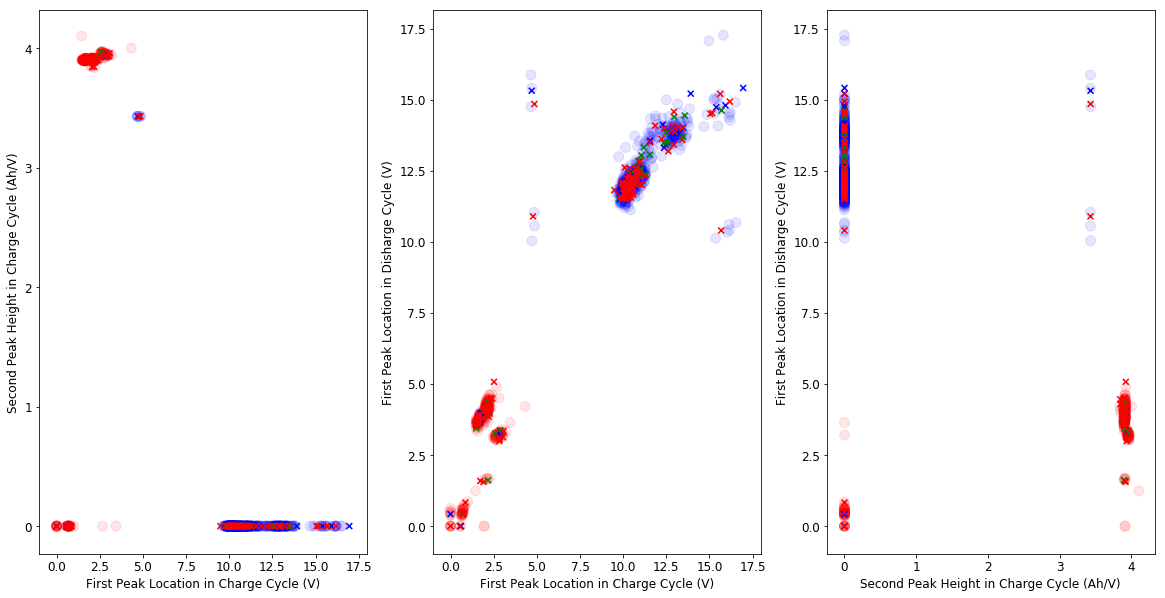

In [23]:
#incorrect predictions are shown by green x's 

f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(20, 10))
ax1.scatter(datatot['ch_5'], datatot['ch_7'], c = datatot['Color'], alpha=0.1, s=100)
ax1.scatter(test_x['ch_5'], test_x['ch_7'], c = test_x['Predicted Col'], marker = "x")
ax1.set_xlabel('First Peak Location in Charge Cycle (V)')
ax1.set_ylabel('Second Peak Height in Charge Cycle (Ah/V)')
ax2.scatter(datatot['ch_5'], datatot['dc_5'], c = datatot['Color'], alpha=0.1, s=100)
ax2.scatter(test_x['ch_5'], test_x['dc_5'], c = test_x['Predicted Col'], marker = "x")
ax2.set_xlabel('First Peak Location in Charge Cycle (V)')
ax2.set_ylabel('First Peak Location in Disharge Cycle (V)')
ax3.scatter(datatot['ch_7'], datatot['dc_5'], c = datatot['Color'], alpha=0.1, s=100)
ax3.scatter(test_x['ch_7'], test_x['dc_5'], c = test_x['Predicted Col'], marker = "x")
ax3.set_xlabel('Second Peak Height in Charge Cycle (Ah/V)')
ax3.set_ylabel('First Peak Location in Disharge Cycle (V)')

plt.show()